# 1) Importations

In [559]:
%pylab inline
import pandas as pd
import os
import seaborn as sns
import random
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from sklearn import preprocessing, decomposition, manifold, cluster
import pickle
from matplotlib.patches import Patch
import matplotlib as mpl
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

Populating the interactive namespace from numpy and matplotlib


/home/noel/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def dynamic_std_print(string_to_print):
    """
    Printing string on standard output and refreshing output line
    """
    sys.stdout.write('\r')
    sys.stdout.write(string_to_print)
    sys.stdout.flush()

In [3]:
def extract_text(df):
    """
    Take genres and keywords from main dataframe and output list regrouping those
    """
    # Convert to lower case
    genres = df.genres.lower()
    kw = df.keywords.lower()
    return genres.split(',') + kw.split(',')

In [4]:
def switch_term(terms_list, old_term, new_term):
    for i in range(len(terms_list)):
        terms_list[i] = terms_list[i].replace(old_term, new_term)
    return terms_list

In [5]:
def assign_genres(row, genre_column) :
    """
    Short routine to populate the rows of the genre DF
    """
    genre_found = 0
    string_genres = row.loc['genres'].lower()
    genres_list = string_genres.split(",")
    if genre_column in genres_list :
        genre_found = 1
    return genre_found

In [193]:
def isgenre(row, genre):
    isgenre = False
    if genre in row.genres_list:
        isgenre = True
    elif genre in row.kw_list:
        isgenre = True
    if isgenre:
        out = 1
    else:
        out = 0
    return out

In [63]:
def generate_batch(pairs, n_positive=50, negative_ratio=1.0, classification=False):
    """
    Generate batches of samples for training
    """
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Get pairs set
    pairs_set = set(pairs)

    # Adjust label based on task
    if classification:
        neg_label = 0
    else:
        neg_label = -1
    
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (movie_id, kw_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (movie_id, kw_id, 1)

        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_movie = random.randrange(genres_kw_df.shape[0])
            random_kw = random.randrange(len(unique_keywords))
            
            # Check to make sure this is not a positive example
            if (random_movie, random_kw) not in pairs_set:
                
                # Add to batch and increment index
                batch[idx, :] = (random_movie, random_kw, neg_label)
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'movie': batch[:, 0], 'kw': batch[:, 1]}, batch[:, 2]

In [69]:
def movies_embedding_model(movies_shape, kw_shape, embedding_size=50, classification=False):
    """
    Model to embed books and wikilinks using the functional API.
    Trained to discern if a movie is of a particular genre
    """
    
    # Both inputs are 1-dimensional
    movie = Input(name = 'movie', shape = [1])
    kw = Input(name = 'kw', shape = [1])
    
    # Embedding the movies (shape will be (None, 1, 50))
    movie_embedding = Embedding(name = 'movie_embedding',
                                 input_dim = movies_shape,
                                 output_dim = embedding_size)(movie)
    
    
    # Embedding the keywords (shape will be (None, 1, 50))
    kw_embedding = Embedding(name = 'kw_embedding',
                            input_dim = kw_shape,
                            output_dim = embedding_size)(kw)
    
    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([movie_embedding, kw_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [movie, kw], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [movie, kw], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

In [76]:
def train_embedding(pairs, shape_movies, shape_kw, n_positive=1000, emb_size=50, verb=1):
    """
    Train neural network
    """
    # Instantiate model and show parameters
    model = movies_embedding_model(shape_movies, shape_kw)
 
    # Generate batch
    gen = generate_batch(pairs, n_positive, negative_ratio=2, classification=True)

    # Train
    h = model.fit_generator(gen, epochs=10, 
                            steps_per_epoch=len(pairs) // n_positive,
                            verbose=verb)
    return h, model

In [10]:
def extract_embedding(layer, selection_id):
    """
    Output trained weights from embedding layer and use it to get closest recommendations
    """
    # Extract embeddings
    weights = layer.get_weights()[0]
    # Normalize weights
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    # Calculate dot product between movie and all others
    dists = np.dot(weights, weights[selection_id])
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    # Take the last n sorted distances
    closest = sorted_dists[-11:]
    closest = [x for x in reversed(closest)]
    return closest, weights

In [11]:
def recom_genres(ref_genres, recommendation_df):
    """
    bar plot of genre in recommendations
    """
    list_genres = ref_genres.split(',')
    genres_recom = pd.Series(",".join(recommendation_df.genres.values.tolist()).split(",")).value_counts()
    # Gather all genres (ref and recom)
    all_genres = set(list_genres + genres_recom.index.values.tolist())
    # Get other genres
    other_genres = all_genres - set(list_genres)
    # Create serie for bar plot
    genres_bar_df = pd.Series(0, index=[list_genres + list(other_genres)])
    # Fill bar plot
    for genre in genres_recom.index:
        genres_bar_df.loc[genre] = genres_recom.loc[genre]
    return genres_bar_df

In [12]:
def recom_kw(ref_kw, recommendation_df):
    """
    Histogram of keywords in recommendations
    """
    list_kw = ref_kw.split(',')
    kw_recom = pd.Series(",".join(recommendation_df.keywords.values.tolist()).split(",")).value_counts()
    # Gather all kw (ref and recom)
    all_kw = set(list_kw + kw_recom.index.values.tolist())
    # Get other kw
    other_kw = all_kw - set(list_kw)
    # Create serie for histogram
    kw_histo_df = pd.Series(0, index=[list_kw + list(other_kw)])
    # Fill histogram
    for kw in kw_recom.index:
        kw_histo_df.loc[kw] = kw_recom.loc[kw]
    return kw_histo_df

In [13]:
# get a color map
my_cmap = cm.get_cmap('jet')
# get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=12)
# some boring fake data
myblue = 3
myorange = 9

# 2) Data loading

In [14]:
# Getting current path
path = os.getcwd()
file = '/data/movie_metadata_large.csv'
# file = ''/data/movie_metadata.csv'

# Verifying data presence
try :
    data_raw = pd.read_csv(path + file, sep=',')
except FileNotFoundError :
    print("Please check if the file %s is in the 'data' folder at the current location" % file)

# 3) Data first observation

In [15]:
data_raw.shape

(53705, 4)

Not to big of a dataset, what's in it ?

In [16]:
data_raw.head()

,title,cast,genres,keywords
0,Batman & Robin,"George Clooney,Chris O'Donnell,Arnold Schwarze...","Science Fiction,Action,Fantasy,Comedy","double life,dc comics,dual identity,crime figh..."
1,About the Looking for and the Finding of Love,"Moritz Bleibtreu,Alexandra Maria Lara,Uwe Ochs...","Comedy,Drama","berlin germany,suicide,lovesickness,greece,com..."
2,The Life Aquatic with Steve Zissou,"Bill Murray,Anjelica Huston,Cate Blanchett,Wil...","Adventure,Comedy,Drama","parent child relationship,red cap,rivalry,dysf..."
3,8½,"Marcello Mastroianni,Claudia Cardinale,Anouk A...","Fantasy,Drama","individual,scapegoat,adultery,screenplay,cinec..."
4,The Pianist,"Adrien Brody,Thomas Kretschmann,Frank Finlay,M...","Drama,War","resistance,holocaust,hunger,world war ii,priso..."


Obvious duplicates ?

In [17]:
data_raw[data_raw.duplicated()].shape

(12, 4)

Drop obvious duplicates if any

In [18]:
data_raw = data_raw.drop_duplicates(keep='first')
data_raw.shape

(53693, 4)

Movies duplicates ?

In [19]:
dup = data_raw[data_raw.duplicated(subset=["title"])]
n_dup = dup.shape[0]
print("%i duplicates sharing movie title" % n_dup)
print(dup.title.head(10))

2825 duplicates sharing movie title
49                       Shaft
303                    The Fog
311          Annaluise & Anton
318                   The Omen
383         Planet of the Apes
424    The Thomas Crown Affair
434           Dawn of the Dead
524         The Miracle Worker
640    Blood: The Last Vampire
753                      Crash
Name: title, dtype: object


Duplicates are most likely remakes

In [20]:
data_raw[data_raw.title == "The Thomas Crown Affair"]

,title,cast,genres,keywords
423,The Thomas Crown Affair,"Steve McQueen,Faye Dunaway,Paul Burke,Jack Wes...","Romance,Crime,Thriller,Drama","in love with enemy,hold-up robbery,boredom,ins..."
424,The Thomas Crown Affair,"Pierce Brosnan,Rene Russo,Denis Leary,Ben Gazz...","Drama,Crime,Romance","martinique,claude monet,famous painting,glider..."


# 4) Missing values

In [21]:
data_raw.isna().sum()

title           0
cast         5271
genres       5496
keywords    21723
dtype: int64

Remove rows with missing values

In [22]:
data_raw = data_raw.dropna()
data_raw.shape

(29819, 4)

In [23]:
data_raw.isna().sum()

title       0
cast        0
genres      0
keywords    0
dtype: int64

# 5) More Feature Engineering

In [24]:
data_raw.sample(5)

,title,cast,genres,keywords
10177,Bride Flight,"Karina Smulders,Waldemar Torenstra,Anna Drijve...",Drama,"baby,emigration,adoption,pregnancy,airplane,vi..."
29716,The Bet,"Didier Bourdon,Bernard Campan,Isabelle Ferron,...",Comedy,"smoking,cigarette"
4697,United 93,"J.J. Johnson,Polly Adams,Trish Gates,Nancy McD...","Drama,History,Crime,Thriller,Action","war on terror,airplane,hijacking,terror cell,e..."
28355,Six: The Mark Unleashed,"Stephen Baldwin,David A.R. White,Jeffrey Dean ...","Action,Thriller",christian
10551,A Christmas Carol,"Gary Oldman,Jim Carrey,Steve Valentine,Daryl S...","Animation,Drama,Family","holiday,based on novel or book,victorian engla..."


Pass genres to lowercase

In [25]:
data_raw.loc[:, 'genres'] = data_raw.genres.apply(lambda x: x.lower())

In [26]:
data_raw.loc[:, 'text'] = data_raw.apply(extract_text, axis=1)

In [27]:
data_raw.head()

,title,cast,genres,keywords,text
0,Batman & Robin,"George Clooney,Chris O'Donnell,Arnold Schwarze...","science fiction,action,fantasy,comedy","double life,dc comics,dual identity,crime figh...","[science fiction, action, fantasy, comedy, dou..."
1,About the Looking for and the Finding of Love,"Moritz Bleibtreu,Alexandra Maria Lara,Uwe Ochs...","comedy,drama","berlin germany,suicide,lovesickness,greece,com...","[comedy, drama, berlin germany, suicide, loves..."
2,The Life Aquatic with Steve Zissou,"Bill Murray,Anjelica Huston,Cate Blanchett,Wil...","adventure,comedy,drama","parent child relationship,red cap,rivalry,dysf...","[adventure, comedy, drama, parent child relati..."
3,8½,"Marcello Mastroianni,Claudia Cardinale,Anouk A...","fantasy,drama","individual,scapegoat,adultery,screenplay,cinec...","[fantasy, drama, individual, scapegoat, adulte..."
4,The Pianist,"Adrien Brody,Thomas Kretschmann,Frank Finlay,M...","drama,war","resistance,holocaust,hunger,world war ii,priso...","[drama, war, resistance, holocaust, hunger, wo..."


In [28]:
# Filter out stop words
stop_words = set(stopwords.words('english'))

In [29]:
# Modifying the genres as well
data_raw.loc[:, 'genres'] = data_raw.loc[:, 'genres'].apply(lambda x: x.replace('science fiction', 'scifi'))

In [30]:
# Get splitted genres in a serie
s = data_raw.genres.str.lower().str.split(",").values.tolist()
# Get unique genres
unique_genres = [genres_out for genres_in in s for genres_out in genres_in]
unique_genres = set(unique_genres)
unique_genres = list(unique_genres)
print("%i genres in the dataset" % len(unique_genres))

19 genres in the dataset


In [322]:
# Get splitted keywords in a serie
s = data_raw.keywords.str.lower().str.split(",").values.tolist()
# Get unique keywords
keywords = [keywords_out for keywords_in in s for keywords_out in keywords_in]
# Remove stopwords
stop_words = set(stopwords.words('english'))
keywords_tokens_sw = [w for w in keywords if not w in stop_words]
set_keywords = set(keywords_tokens_sw)
unique_keywords = list(set_keywords)
print("%i keywords in the dataset" % len(unique_keywords))

17624 keywords in the dataset


Feature engineering for genres : let's do some OneHot encoding manually. We expect one feature by genre

In [32]:
# Initialize the genres df
genres_df = pd.DataFrame(columns=unique_genres, dtype=int)

In [33]:
# Assign genres to entries
for genre in unique_genres :
    genres_df.loc[:, genre] = data_raw.apply(assign_genres, axis=1, args=(genre,))
genres_df = genres_df.reset_index(drop=True)

Well, have a look at our new genre df

In [34]:
genres_df.head()

,romance,western,adventure,music,scifi,horror,comedy,history,tv movie,thriller,documentary,family,drama,war,mystery,animation,action,fantasy,crime
0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [35]:
genres_kw_df = data_raw.loc[:, ['title', 'genres', 'keywords']]
genres_kw_df = genres_kw_df.reset_index(drop=True)
genres_kw_df.head(1)

,title,genres,keywords
0,Batman & Robin,"scifi,action,fantasy,comedy","double life,dc comics,dual identity,crime figh..."


In [36]:
# Take strings and output list of tokens
genres_kw_df.loc[:, 'genres_list'] = genres_kw_df.genres.apply(lambda x: x.lower().split(","))
genres_kw_df.loc[:, 'kw_list'] = genres_kw_df.keywords.apply(lambda x: x.lower().split(","))

In [37]:
genres_kw_df.loc[:, 'genres_list'] = genres_kw_df.genres_list.apply(switch_term, args=('sci-fi', ('scifi')))
genres_kw_df.loc[:, 'kw_list'] = genres_kw_df.kw_list.apply(switch_term, args=('sci fi', ('scifi')))

In [38]:
genres_kw_df.loc[:, 'genres_str'] = genres_kw_df.genres_list.apply(lambda x: " ".join([w for w in " ".join(x).split() if not w in stop_words]))
genres_kw_df.loc[:, 'kw_str'] = genres_kw_df.kw_list.apply(lambda x: " ".join([w for w in " ".join(x).split() if not w in stop_words]))
genres_kw_df.loc[:, 'genres_len'] = genres_kw_df.genres_str.apply(lambda x: len(x))
genres_kw_df.loc[:, 'kw_len'] = genres_kw_df.kw_str.apply(lambda x: len(x))

In [39]:
genres_kw_df.head(3)

,title,genres,keywords,genres_list,kw_list,genres_str,kw_str,genres_len,kw_len
0,Batman & Robin,"scifi,action,fantasy,comedy","double life,dc comics,dual identity,crime figh...","[scifi, action, fantasy, comedy]","[double life, dc comics, dual identity, crime ...",scifi action fantasy comedy,double life dc comics dual identity crime figh...,27,111
1,About the Looking for and the Finding of Love,"comedy,drama","berlin germany,suicide,lovesickness,greece,com...","[comedy, drama]","[berlin germany, suicide, lovesickness, greece...",comedy drama,berlin germany suicide lovesickness greece com...,12,173
2,The Life Aquatic with Steve Zissou,"adventure,comedy,drama","parent child relationship,red cap,rivalry,dysf...","[adventure, comedy, drama]","[parent child relationship, red cap, rivalry, ...",adventure comedy drama,parent child relationship red cap rivalry dysf...,22,158


In [40]:
max_length_genres = genres_kw_df.genres_len.max()
max_length_kw = genres_kw_df.kw_len.max()
print(max_length_genres, max_length_kw)

67 792


Supervised learning issue : is the movie of specific genre ?

In [41]:
genres_kw_df.head(3)

,title,genres,keywords,genres_list,kw_list,genres_str,kw_str,genres_len,kw_len
0,Batman & Robin,"scifi,action,fantasy,comedy","double life,dc comics,dual identity,crime figh...","[scifi, action, fantasy, comedy]","[double life, dc comics, dual identity, crime ...",scifi action fantasy comedy,double life dc comics dual identity crime figh...,27,111
1,About the Looking for and the Finding of Love,"comedy,drama","berlin germany,suicide,lovesickness,greece,com...","[comedy, drama]","[berlin germany, suicide, lovesickness, greece...",comedy drama,berlin germany suicide lovesickness greece com...,12,173
2,The Life Aquatic with Steve Zissou,"adventure,comedy,drama","parent child relationship,red cap,rivalry,dysf...","[adventure, comedy, drama]","[parent child relationship, red cap, rivalry, ...",adventure comedy drama,parent child relationship red cap rivalry dysf...,22,158


#### Encode all genres and keywords strings : our data should be integers

In [323]:
# Initiate label encoder
le_grs = preprocessing.LabelEncoder()
# Fit strings of genres
le_grs.fit(genres_kw_df.genres_str)
# Transform strings of genres from encoding
genres_kw_df.loc[:, 'enc_grs'] = le_grs.transform(genres_kw_df.genres_str)
# Initiate label encoder
le_kw = preprocessing.LabelEncoder()
# Fit strings of genres
le_kw.fit(genres_kw_df.kw_str)
# Transform strings of kw from encoding
genres_kw_df.loc[:, 'enc_kw'] = le_kw.transform(genres_kw_df.kw_str)
# Turn movies title and encoded genres string into dictionnary
genres_kw_df.loc[:, 'enc'] = genres_kw_df.loc[:, ['enc_grs', 'enc_kw']].apply(lambda x: [x.enc_grs, x.enc_kw], axis=1)
genres_index = dict(zip(genres_kw_df.title, genres_kw_df.enc_grs))
kw_index = {kw: idx for idx, kw in enumerate(unique_keywords)}
# Building reverse dictionnary
index_genres = {idx: movie for movie, idx in genres_index.items()}
index_kw = {idx: kw for kw, idx in kw_index.items()}
# Have a look at our dictionnaries
print('Genres string encoded for movie "Avatar" : %i' % genres_index['Avatar'])
print('Movie s title for encoded string number 106 : "%s"' % index_genres[106])

Genres string encoded for movie "Avatar" : 150
Movie s title for encoded string number 106 : "The Golden Voyage of Sinbad"


In [326]:
n_genres_combis = np.unique(np.array(list(index_genres.keys()))).shape[0]
n_kw_combi = np.unique(np.array(list(index_kw.keys()))).shape[0]
print("We have %i genres combinations" % n_genres_combis)
print("We have %i keywords" % n_kw_combi)

We have 3168 genres combinations
We have 17624 keywords


### Building pairs for supervised training : is a specific keyword in the movies keywords ?

In [328]:
pairs = []

# Iterate through each movie
for i in range(0, genres_kw_df.shape[0]):
    dynamic_std_print('Movie %i / %i' % (i, genres_kw_df.shape[0]))
    # Iterate through the keywords of the movies
    pairs.extend((i, kw_index[kw]) for kw in genres_kw_df.iloc[i,:].kw_list if kw in unique_keywords)

Movie 29818 / 29819

In [343]:
print('We have less than %i positives examples' % (ceil(len(pairs) / 10000) * 10000))

We have less than 150000 positives examples


Define batch-generating function

In [64]:
next(generate_batch(pairs, n_positive=2, negative_ratio=2))

({'movie': array([20693.,  9075., 15959., 20659., 15116., 27674.]),
  'kw': array([ 2713.,  7893.,  5197., 10238., 10317.,   137.])},
 array([-1.,  1., -1., -1.,  1., -1.]))

Save input dataframe for easy loading and usage in hard code

In [595]:
# pickle.dump(genres_kw_df, open('data/input_df_embedding.pkl', 'wb'))

Save genres and keywords encoders for easy loading and usage in hard code

In [66]:
# pickle.dump(le_grs, open('data/genres_encoder.pkl', 'wb'))
# pickle.dump(le_kw, open('data/keywords_encoder.pkl', 'wb'))

Snippet of code to find movie based on its title

In [67]:
# genres_kw_df[genres_kw_df['title'].str.contains("Kung")]

# Neural Network Model

In [330]:
n_positive = 1000
history, emb_model = train_embedding(pairs, genres_kw_df.shape[0], len(unique_keywords), n_positive)

Epoch 1/10
148/148 [==============================] - 15s 98ms/step - loss: 0.3080
Epoch 2/10
148/148 [==============================] - 14s 94ms/step - loss: 0.2292
Epoch 3/10
148/148 [==============================] - 14s 94ms/step - loss: 0.1800
Epoch 4/10
148/148 [==============================] - 14s 93ms/step - loss: 0.1417
Epoch 5/10
148/148 [==============================] - 14s 94ms/step - loss: 0.1088
Epoch 6/10
148/148 [==============================] - 14s 96ms/step - loss: 0.0912
Epoch 7/10
148/148 [==============================] - 14s 94ms/step - loss: 0.0729
Epoch 8/10
148/148 [==============================] - 14s 94ms/step - loss: 0.0737
Epoch 9/10
148/148 [==============================] - 14s 92ms/step - loss: 0.0705
Epoch 10/10
148/148 [==============================] - 14s 92ms/step - loss: 0.0703


In [331]:
movie_id = 0

In [332]:
# Get layer
layer = emb_model.get_layer('movie_embedding')
# Extract weights
recommendation, movies_weights = extract_embedding(layer, movie_id)
# Get recommendations (closest movies)
recom_df = genres_kw_df.loc[recommendation[1:], ['title', 'genres', 'keywords']]
# Display reference
display(genres_kw_df.loc[movie_id, ['title', 'genres', 'keywords']].to_frame())
# Display recommendation
display(recom_df)
# Get recommendations genres
genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
# Count genres of selected movie
n_genres = len(genres_kw_df.loc[movie_id, :].genres_list)
# Process recommendation genres
genres_recommendation = recom_genres(genres_kw_df.loc[movie_id, :].genres, recom_df)
# Compute genres accuracy for recommendations
genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
print('Genres accuracy : {:.2f}'.format(genres_accuracy))
# Count kw of selected movie
n_kw = len(genres_kw_df.loc[movie_id, :].kw_list)
# Process recommendation keywords
keywords_recommendation = recom_kw(genres_kw_df.loc[movie_id, :].keywords, recom_df)
# Compute kw accuracy for recommendations
kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
print('Keywords accuracy : {:.2f}'.format(kw_accuracy))

,0
title,Batman & Robin
genres,"scifi,action,fantasy,comedy"
keywords,"double life,dc comics,dual identity,crime figh..."


,title,genres,keywords
12636,The Trial of the Incredible Hulk,"adventure,fantasy,drama,action,scifi","dual identity,crime fighter,witness,transforma..."
16159,Defendor,"drama,action,comedy,crime","crime fighter,delusion,superhero"
3063,Der Novembermann,drama,"double life,dual identity"
20932,Superman/Batman: Apocalypse,"action,adventure,animation,family,scifi","dc comics,superhero,superhuman,super power,wom..."
24762,The Science of Superman,documentary,"superhero,super power,superhuman strength"
25973,Kick-Ass 2,"action,adventure,crime","crime fighter,secret identity,superhero,based ..."
4247,Supergirl,"adventure,fantasy,action,scifi","dc comics,magic,laser,power,superhero,based on..."
11223,Kick-Ass,"action,crime","crime fighter,secret identity,comic book,super..."
29534,Outrage,"drama,crime","rape,trauma,faith,clergyman,woman director"
3599,Dick Tracy,"adventure,action,comedy,thriller,crime","corruption,crime fighter,gangster,investigatio..."


Genres accuracy : 0.44
Keywords accuracy : 0.26


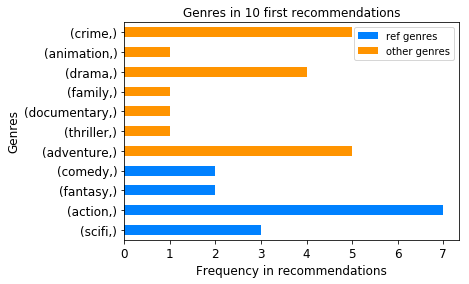

In [333]:
# Process recommendation genres
genres_recommendation = recom_genres(genres_kw_df.loc[movie_id, :].genres, recom_df)
# Define vector for colors
my_data = [myblue]*n_genres + (genres_recommendation.shape[0] - n_genres)*[myorange]
# Plot bar plot
genres_recommendation.plot.barh(color=my_cmap(my_norm(my_data)), fontsize=12)
# Get axes for graph tuning
ax = plt.gca()
# Set legend elements
legend_elements = [Patch(facecolor=my_cmap(my_norm([3]))[0], label='ref genres'),
                   Patch(facecolor=my_cmap(my_norm([9]))[0], label='other genres')]
# Create handmade legend
ax.legend(handles=legend_elements)
# Set axis labels and title
ax.set_xlabel("Frequency in recommendations", fontsize=12)
ax.set_ylabel("Genres", fontsize=12)
ax.set_title("Genres in 10 first recommendations", fontsize=12);

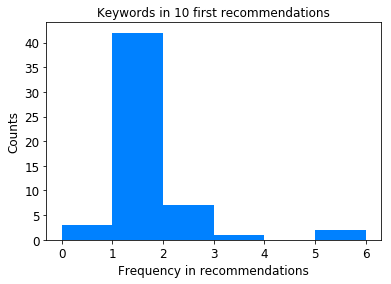

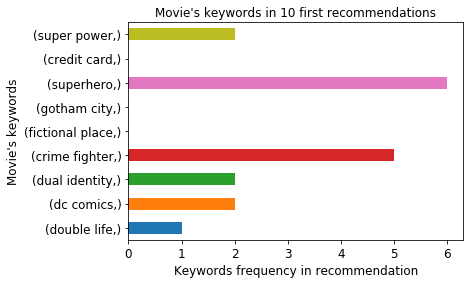

In [335]:
# Process recomendation keywords
keywords_recommendation = recom_kw(genres_kw_df.loc[movie_id, :].keywords, recom_df)
# Define vector for colors
my_data = [myblue]*n_kw + (keywords_recommendation.shape[0] - n_kw)*[myorange]

# Plot
# First plot : movie's keywords histogram
fig, ax = plt.subplots()
ax = keywords_recommendation.plot.hist(color=my_cmap(my_norm(my_data)), fontsize=12, bins=len(keywords_recommendation.unique()))
# Set axis labels and title
ax.set_xlabel("Frequency in recommendations", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
ax.set_title("Keywords in 10 first recommendations", fontsize=12)
# pyplot.locator_params(axis='x', nbins=3)

# Second plot : movie's keywords frequency
fig, ax = plt.subplots()
# Movie's keywords for barplot
movie_kw = keywords_recommendation.loc[genres_kw_df.loc[movie_id, :].kw_list]
ax = movie_kw.plot.barh(fontsize=12)
# Set axis labels and title
ax.set_xlabel("Keywords frequency in recommendation", fontsize=12)
ax.set_ylabel("Movie's keywords", fontsize=12)
ax.set_title("Movie's keywords in 10 first recommendations", fontsize=12);

## Visualisations

PCA

Treating 49

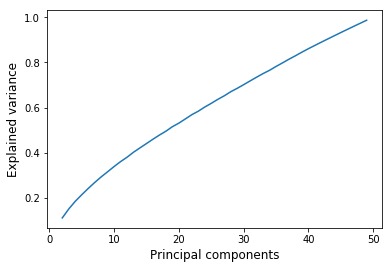

In [344]:
ratios = []
components = np.arange(2,50)
for i in components:
    dynamic_std_print("Treating {:d}".format(i))
    visu_pca = decomposition.PCA(n_components=i)
    visu_pca.fit(movies_weights)
    ratios.append(visu_pca.explained_variance_ratio_.sum())
plt.plot(components, ratios)
plt.xlabel('Principal components', fontsize=12)
plt.ylabel('Explained variance', fontsize=12);

TSNE

In [345]:
tsne_test = manifold.TSNE(n_components=2, perplexity=50, n_iter=1000, metric='euclidean').fit_transform(movies_weights)

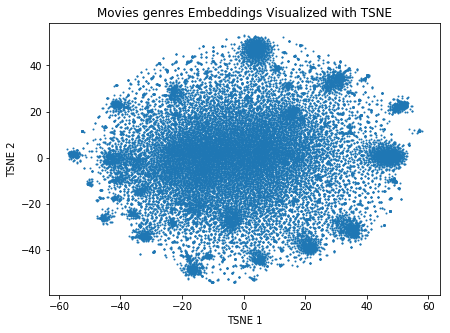

In [346]:
plt.figure(figsize = (7, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], s=1)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

In [347]:
# get a color map with two different colors
cmap_2c = cm.get_cmap('bwr')
# get normalize function (takes data in range [vmin, vmax] -> [0, 1])
norm_2c = Normalize(vmin=0, vmax=1)

## KMEANS clustering on movies weights

Clustering helps us emphasize clusters and then look for sense in those

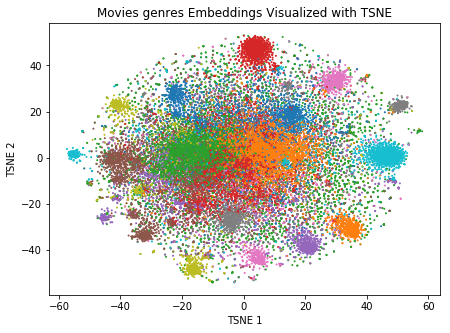

In [348]:
kmeans = cluster.KMeans(n_clusters=20)
kmeans = kmeans.fit(movies_weights)
categs_kmeans = kmeans.predict(movies_weights)
plt.figure(figsize = (7, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=categs_kmeans, s=1,cmap=plt.cm.tab10)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Trying to identify what is the SOUTH cluster

In [361]:
ids_south_cluster = np.where((tsne_test[:, 0] < -10) & (tsne_test[:, 0] > -20) & (tsne_test[:, 1] < -40))[0]
genres_kw_df.loc[ids_south_cluster, ['genres', 'keywords']]

,genres,keywords
565,"drama,action,western,romance","pearl harbor,cowboy,pickup truck,horse riding ..."
1508,drama,short
1992,horror,short
2553,documentary,short
2876,"crime,thriller",poison
4635,"action,comedy,family","human animal relationship,dog,arsonist"
5455,documentary,"diving,sea,fish,atlantic ocean,deep sea,water,..."
6788,"animation,family","stage,banjo,magic,bunny,rabbi,rope,rescue,ange..."
6876,"comedy,drama,fantasy,romance","suicide,independent film,break-up,ex-boyfriend..."
6995,"animation,family","space,robot,short"


Looks like short-related movies to me !

Now check our hypothesis : let's identify the short movies

In [362]:
# Build a test vector for the 'short' keyword
test_short = genres_kw_df.apply(isgenre, args=('short',), axis=1)

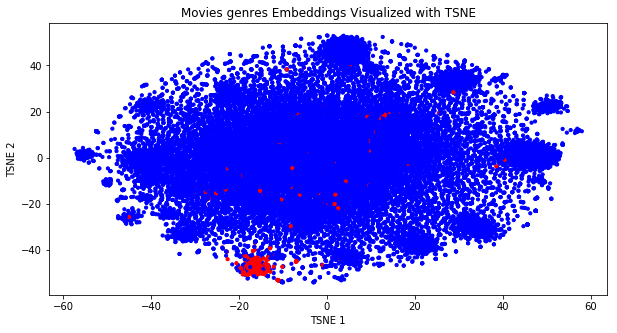

In [363]:
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_short.values)), s=10)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Trying to identify what is the WEST cluster

In [364]:
ids_west_cluster = np.where((tsne_test[:, 0] < -50) & (tsne_test[:, 1] > -10) & (tsne_test[:, 1] < 10))[0]
genres_kw_df.loc[ids_west_cluster, ['genres', 'keywords']]

,genres,keywords
1069,comedy,"sex,erotic movie"
1735,horror,"frankenstein,lesbian,erotic movie"
1744,"comedy,horror","frankenstein,erotic movie"
1881,"comedy,scifi","earth,interior of the earth,kaiser wang,parody..."
1887,drama,erotic movie
2081,comedy,"casanova,erotic movie"
2415,"drama,thriller",erotic movie
2416,"crime,drama,thriller",erotic movie
2440,comedy,erotic movie
2474,"comedy,drama",erotic movie


Looks like erotic movies to me !

Now check our hypothesis : let's identify the erotic movies

In [365]:
# Build a test vector for the 'erotic movie' keyword
test_erotic = genres_kw_df.apply(isgenre, args=('erotic movie',), axis=1)

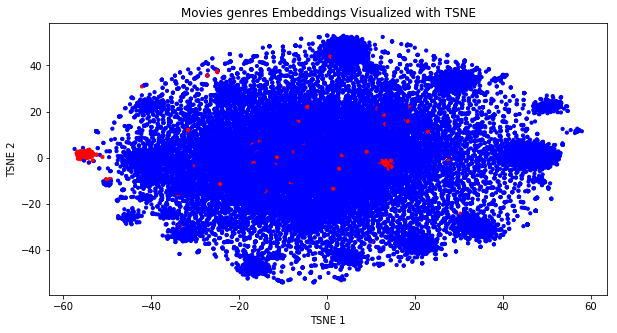

In [366]:
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_erotic.values)), s=10)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Trying to identify what is the NORTH cluster

In [367]:
ids_north_cluster = np.where((tsne_test[:, 0] < 10) & (tsne_test[:, 0] > -5) & (tsne_test[:, 1] > 35))[0]
genres_kw_df.loc[ids_north_cluster, ['genres', 'keywords']]

,genres,keywords
555,documentary,"skateboarding,independent film"
675,"mystery,comedy,drama","bizarre,beauty queen contest,independent film"
679,documentary,independent film
844,"comedy,drama,romance","love triangle,independent film,multiple storyl..."
977,"comedy,horror","parody,parallel world"
1254,comedy,"independent film,aftercreditsstinger,duringcre..."
1279,drama,independent film
1477,"comedy,crime,mystery,romance,thriller","hypnosis,independent film,new york city,insura..."
1518,"drama,romance","knee,independent film,sexual desire"
1795,drama,"london england,grandparent grandchild relation..."


Looks like independent film movies to me !

Now check our hypothesis : let's identify the independant movies

In [368]:
# Build a test vector for the 'independent film' keyword
test_independent = genres_kw_df.apply(isgenre, args=('independent film',), axis=1)

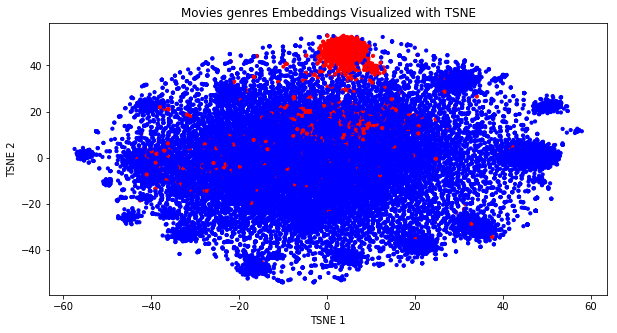

In [369]:
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_independent.values)), s=10)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Trying to identify what is the large MIDDLE cluster

In [370]:
ids_middle_cluster = np.where((tsne_test[:, 0] < 20) & (tsne_test[:, 0] > 0) & (tsne_test[:, 1] > 0) & (tsne_test[:, 1] < 10))[0]
genres_kw_df.loc[ids_middle_cluster, ['genres', 'keywords']]

,genres,keywords
28,"drama,romance","forbidden love,based on play or musical,gun vi..."
36,"drama,romance","sibling relationship,sex,age difference,beach,..."
44,"crime,drama","ambush,sheriff,waitress,prohibition,texas,bank..."
47,"comedy,drama,romance","child abuse,adultery,arranged marriage,wedding..."
49,"adventure,action,thriller,crime","new york,black people,ghetto,daughter,police,b..."
60,"comedy,drama","individual,paris france,algerienkrieg,cancer,s..."
76,"comedy,drama,history","individual,taxi,transsexuality,transvestite,fo..."
77,"drama,horror","germany,confession,depression,1970s,desperatio..."
94,"romance,comedy","surgeon,stalker,romantic comedy,dream girl,tab..."
108,"crime,drama,thriller","new york,post traumatic stress disorder,mexic..."


Looks like sex-related movies to me ! But with lots of keywords making the clustering more difficult

Now check our hypothesis : let's identify the sex movies

In [373]:
# Build a test vector for the 'sex' keyword
test_sex = genres_kw_df.apply(isgenre, args=('sex',), axis=1)

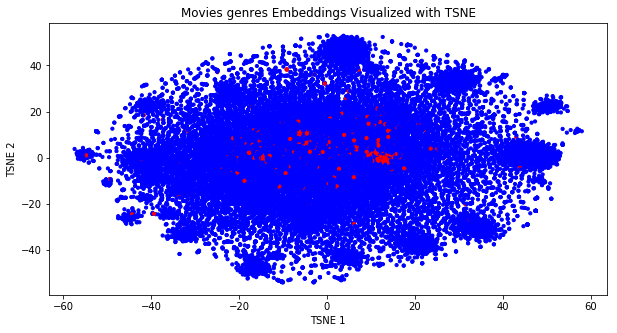

In [374]:
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_sex.values)), s=10)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

This is why this cluster is more spread, the sex movies do not land exactly where we were looking at, this is more representative at the cluster on the left-side of the one we were looking at

Is there a sport-related movies cluster ?

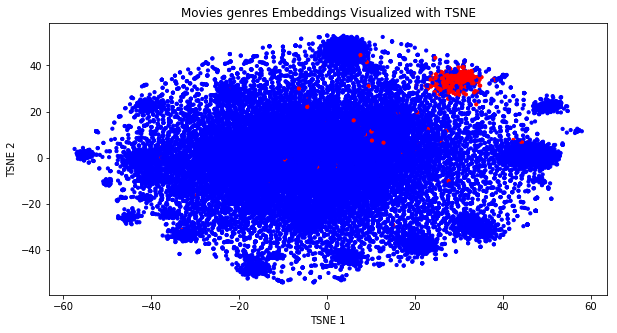

In [375]:
# Build a test vector for the 'sport' keyword
test_sport = genres_kw_df.apply(isgenre, args=('sport',), axis=1)
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_sport.values)), s=10)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Is there a music-related movies cluster ?

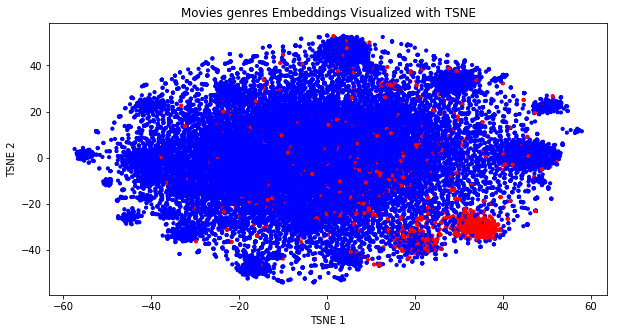

In [376]:
# Build a test vector for the 'music' keyword
test_music = genres_kw_df.apply(isgenre, args=('music',), axis=1)
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_music.values)), s=10)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Is there a suspense-related movies cluster ?

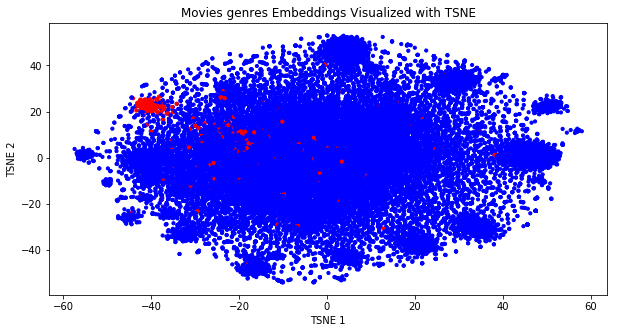

In [377]:
# Build a test vector for the 'suspense' keyword
test_suspense = genres_kw_df.apply(isgenre, args=('suspense',), axis=1)
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_suspense.values)), s=10)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

## Try to color the mapping with most common keywords

Building keywords counts

In [456]:
# Gather all keywords from all movies
movies_keywords = genres_kw_df.kw_list.values.tolist()
movies_keywords_list = [inner for outer in movies_keywords for inner in outer]
# Count occurences
val, counts = np.unique(np.array(movies_keywords_list), return_counts=True)
# Create array for best import to dataframe
count_array = np.hstack([val.reshape(-1,1), counts.reshape(-1,1)])
# Create dataframe
kw_count_df = pd.DataFrame(count_array, columns=['kw', 'count'])
kw_count_df.loc[:, 'count'] = kw_count_df.loc[:, 'count'].astype(int)
kw_count_df = kw_count_df.sort_values('count', ascending=False)
kw_count_df.head(20)

,kw,count
17357,woman director,2106
7885,independent film,2030
10431,murder,1263
1228,based on novel or book,981
10491,musical,890
14031,sex,726
14874,sport,660
15452,suspense,649
16865,violence,615
13116,revenge,586


A few keywords are frequent, others are rare

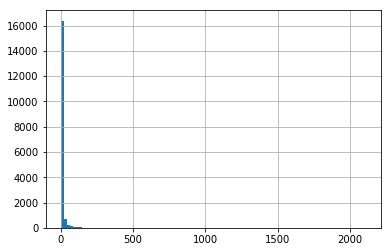

In [440]:
kw_count_df.loc[:, 'count'].hist(bins=100);

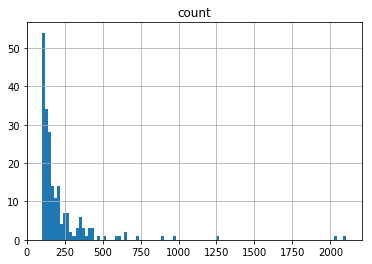

In [439]:
kw_count_df[kw_count_df.loc[:, 'count'] > 100].hist(bins=100);

Get 20 most common keywords

In [475]:
index_most_common_kw = {kw : idw + 1 for idw, kw in enumerate(kw_count_df.head(20).kw.values.tolist())}
index_most_common_kw

{'woman director': 1,
 'independent film': 2,
 'murder': 3,
 'based on novel or book': 4,
 'musical': 5,
 'sex': 6,
 'sport': 7,
 'suspense': 8,
 'violence': 9,
 'revenge': 10,
 'love': 11,
 'short': 12,
 'police': 13,
 'parent child relationship': 14,
 'film noir': 15,
 'world war ii': 16,
 'sequel': 17,
 'biography': 18,
 'concert': 19,
 'martial arts': 20}

In [476]:
def input_color(kw_list, target, value):
    if target in kw_list:
        return value
    else:
        return 0

In [478]:
movies_genres_kw_df = genres_kw_df.loc[:, ['title', 'genres_list', 'kw_list']]
for kw, value in index_most_common_kw.items():
    movies_genres_kw_df.loc[:, kw] = genres_kw_df.kw_list.apply(input_color, args=(kw, value))

In [513]:
def select_color(row):
    if (row == 0).astype(int).sum() != 20:
        return row[row != 0].values[0]
    else:
        return 0
movies_genres_kw_df.loc[:, 'colors'] = movies_genres_kw_df.iloc[:, 3:].apply(select_color, axis=1)

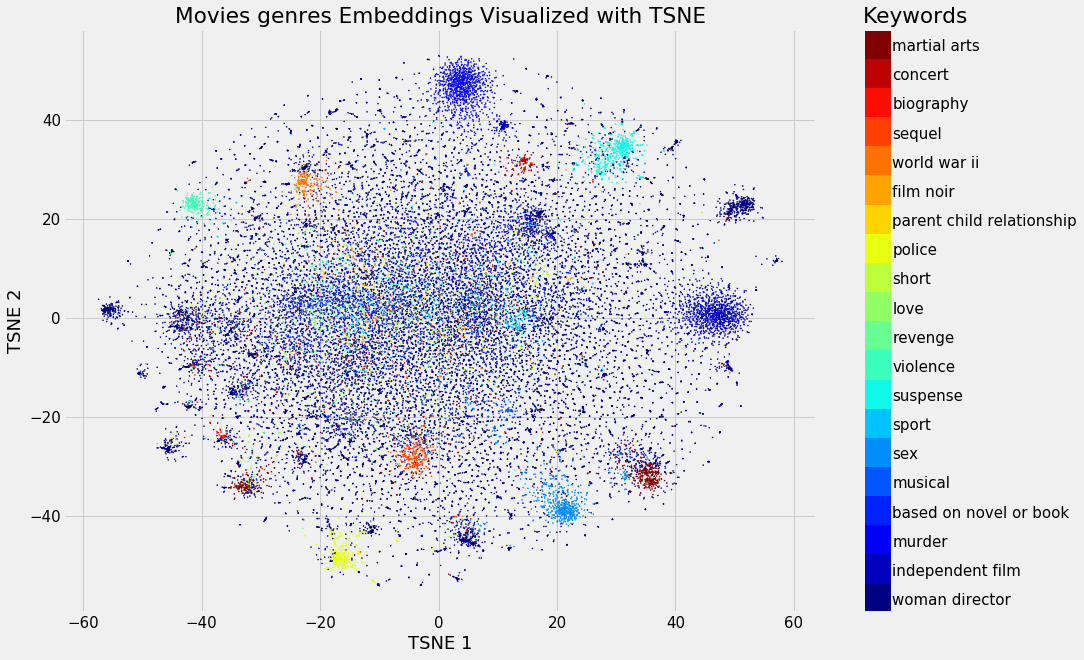

In [594]:
# Plot
plt.figure(figsize = (15, 10))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=movies_genres_kw_df.colors, cmap=cm.get_cmap('jet', 20), s=1)
ax = plt.gca()
ax.set_xlabel('TSNE 1');
ax.set_ylabel('TSNE 2');
ax.set_title('Movies genres Embeddings Visualized with TSNE')
# Add colorbar and appropriate labels
cbar = plt.colorbar(cmap=cmap, norm=norm)
cbar.set_ticks([])
for j, lab in enumerate(index_most_common_kw.keys()):
    cbar.ax.text(20, 0.25 + j, lab)
cbar.ax.set_title('Keywords', loc = 'left');

# Testing plan

We aim to test our recommender system with the following:

- 1) 100 movies of 'drama' type
- 2) 100 movies of 'comedy' type
- 3) 100 movies of 'drama' type and another type
- 4) 100 movies of 'comedy' type and another type
- 5) 100 movies of 'drama' type and two others type
- 6) 100 movies of 'comedy' type and two others type
- 7) 100 movies with the 'woman director' keyword (most common)
- 8) 100 movies with the 'revenge' keyword (quite common)
- 9) 100 movies with the 'robot' keyword (less common, only 102 occurences)
- 10) 20 movies with the 'skyscraper' keyword (rare, only 20 occurences)

In [378]:
drama_movies = genres_kw_df[genres_kw_df.genres == 'drama'].sample(100, random_state=0)
comedy_movies = genres_kw_df[genres_kw_df.genres == 'comedy'].sample(100, random_state=0)
drama2_ind = genres_kw_df.genres_list.apply(lambda x: True if (len(x) == 2) and ('drama' in x) else False)
drama2_movies = genres_kw_df.loc[drama2_ind, :].sample(100, random_state=0)
comedy2_ind = genres_kw_df.genres_list.apply(lambda x: True if (len(x) == 2) and ('comedy' in x) else False)
comedy2_movies = genres_kw_df.loc[comedy2_ind, :].sample(100, random_state=0)
drama3_ind = genres_kw_df.genres_list.apply(lambda x: True if (len(x) == 3) and ('drama' in x) else False)
drama3_movies = genres_kw_df.loc[drama3_ind, :].sample(100, random_state=0)
comedy3_ind = genres_kw_df.genres_list.apply(lambda x: True if (len(x) == 3) and ('comedy' in x) else False)
comedy3_movies = genres_kw_df.loc[comedy3_ind, :].sample(100, random_state=0)

In [450]:
woman_director_movies = genres_kw_df[genres_kw_df['keywords'].str.contains('woman director')].sample(100, random_state=0)
revenge_movies = genres_kw_df[genres_kw_df['keywords'].str.contains('revenge')].sample(100, random_state=0)
robot_movies = genres_kw_df[genres_kw_df['keywords'].str.contains('robot')].sample(100, random_state=0)
skyscraper_movies = genres_kw_df[genres_kw_df['keywords'].str.contains('skyscraper')].sample(20, random_state=0)

### 1) Drama movies test

Movie 99 / 99

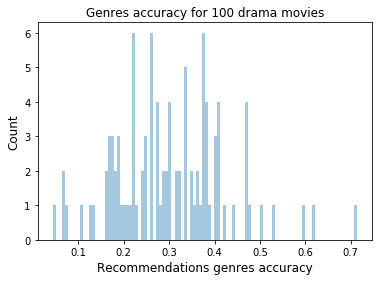

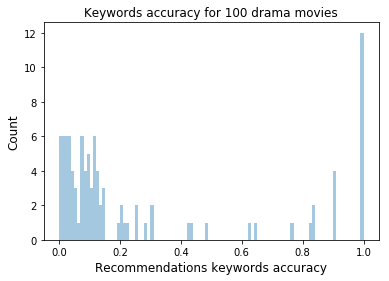

In [412]:
genres_acc_drama1 = []
kw_acc_drama1 = []
for i in range(0,len(drama_movies)):
    dynamic_std_print('Movie %i / %i' % (i, len(drama_movies) - 1))
    # Movie id
    temp_movie_id = drama_movies.iloc[i].name
    # Extract weights
    recom_movie, movies_weights = extract_embedding(layer, temp_movie_id)
    # Get recommendations (closest movies)
    recom_df = genres_kw_df.loc[recom_movie[1:], ['title', 'genres', 'keywords']]
    # Get recommendations genres
    genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
    # Count genres of selected movie
    n_genres = len(genres_kw_df.loc[temp_movie_id, :].genres_list)
    # Process recommendation genres
    genres_recommendation = recom_genres(genres_kw_df.loc[temp_movie_id, :].genres, recom_df)
    # Compute genres accuracy for recommendations
    genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
    genres_acc_drama1.append(genres_accuracy)
    # Count kw of selected movie
    n_kw = len(genres_kw_df.loc[temp_movie_id, :].kw_list)
    # Process recommendation keywords
    keywords_recommendation = recom_kw(genres_kw_df.loc[temp_movie_id, :].keywords, recom_df)
    # Compute kw accuracy for recommendations
    kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
    kw_acc_drama1.append(kw_accuracy)
    
# Genres plot
fig, ax = plt.subplots()
ax = sns.distplot(genres_acc_drama1, bins=100, kde=False)
ax.set_xlabel("Recommendations genres accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Genres accuracy for 100 drama movies", fontsize=12)
# Keywords plot
fig, ax = plt.subplots()
ax = sns.distplot(kw_acc_drama1, bins=100, kde=False)
ax.set_xlabel("Recommendations keywords accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Keywords accuracy for 100 drama movies", fontsize=12);

### 2) Comedy movies test

Movie 99 / 99

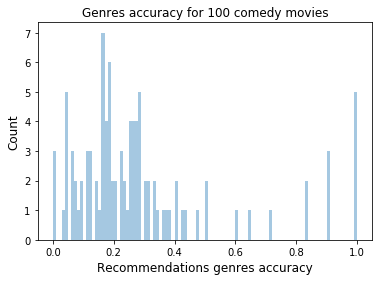

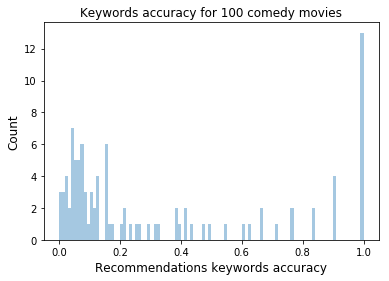

In [413]:
genres_acc_comedy1 = []
kw_acc_comedy1 = []
for i in range(0,len(comedy_movies)):
    dynamic_std_print('Movie %i / %i' % (i, len(comedy_movies) - 1))
    # Movie id
    temp_movie_id = comedy_movies.iloc[i].name
    # Extract weights
    recom_movie, movies_weights = extract_embedding(layer, temp_movie_id)
    # Get recommendations (closest movies)
    recom_df = genres_kw_df.loc[recom_movie[1:], ['title', 'genres', 'keywords']]
    # Get recommendations genres
    genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
    # Count genres of selected movie
    n_genres = len(genres_kw_df.loc[temp_movie_id, :].genres_list)
    # Process recommendation genres
    genres_recommendation = recom_genres(genres_kw_df.loc[temp_movie_id, :].genres, recom_df)
    # Compute genres accuracy for recommendations
    genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
    genres_acc_comedy1.append(genres_accuracy)
    # Count kw of selected movie
    n_kw = len(genres_kw_df.loc[temp_movie_id, :].kw_list)
    # Process recommendation keywords
    keywords_recommendation = recom_kw(genres_kw_df.loc[temp_movie_id, :].keywords, recom_df)
    # Compute kw accuracy for recommendations
    kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
    kw_acc_comedy1.append(kw_accuracy)
    
# Genres plot
fig, ax = plt.subplots()
ax = sns.distplot(genres_acc_comedy1, bins=100, kde=False)
ax.set_xlabel("Recommendations genres accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Genres accuracy for 100 comedy movies", fontsize=12)
# Keywords plot
fig, ax = plt.subplots()
ax = sns.distplot(kw_acc_comedy1, bins=100, kde=False)
ax.set_xlabel("Recommendations keywords accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Keywords accuracy for 100 comedy movies", fontsize=12);

### 3) Drama + another genre movies test

Movie 99 / 99

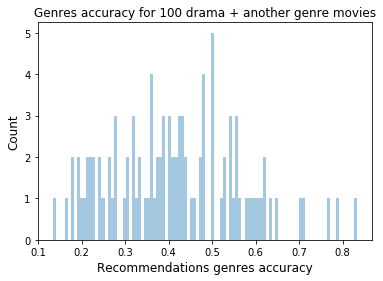

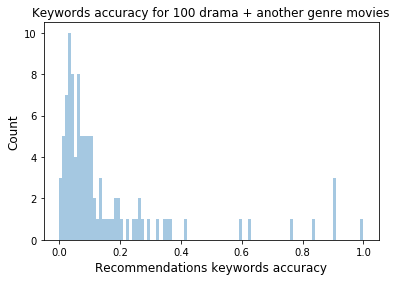

In [415]:
genres_acc_drama2 = []
kw_acc_drama2 = []
for i in range(0,len(drama2_movies)):
    dynamic_std_print('Movie %i / %i' % (i, len(drama2_movies) - 1))
    # Movie id
    temp_movie_id = drama2_movies.iloc[i].name
    # Extract weights
    recom_movie, movies_weights = extract_embedding(layer, temp_movie_id)
    # Get recommendations (closest movies)
    recom_df = genres_kw_df.loc[recom_movie[1:], ['title', 'genres', 'keywords']]
    # Get recommendations genres
    genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
    # Count genres of selected movie
    n_genres = len(genres_kw_df.loc[temp_movie_id, :].genres_list)
    # Process recommendation genres
    genres_recommendation = recom_genres(genres_kw_df.loc[temp_movie_id, :].genres, recom_df)
    # Compute genres accuracy for recommendations
    genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
    genres_acc_drama2.append(genres_accuracy)
    # Count kw of selected movie
    n_kw = len(genres_kw_df.loc[temp_movie_id, :].kw_list)
    # Process recommendation keywords
    keywords_recommendation = recom_kw(genres_kw_df.loc[temp_movie_id, :].keywords, recom_df)
    # Compute kw accuracy for recommendations
    kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
    kw_acc_drama2.append(kw_accuracy)
    
# Genres plot
fig, ax = plt.subplots()
ax = sns.distplot(genres_acc_drama2, bins=100, kde=False)
ax.set_xlabel("Recommendations genres accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Genres accuracy for 100 drama + another genre movies", fontsize=12)
# Keywords plot
fig, ax = plt.subplots()
ax = sns.distplot(kw_acc_drama2, bins=100, kde=False)
ax.set_xlabel("Recommendations keywords accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Keywords accuracy for 100 drama + another genre movies", fontsize=12);

### 4) Comedy  + another genre movies test

Movie 99 / 99

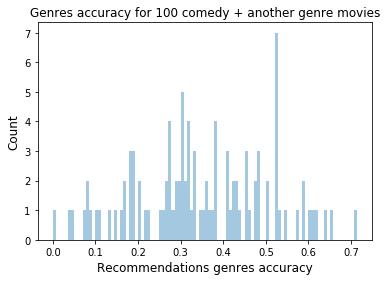

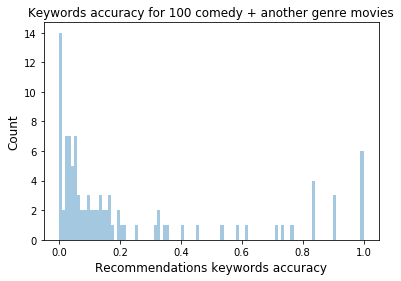

In [416]:
genres_acc_comedy2 = []
kw_acc_comedy2 = []
for i in range(0,len(comedy2_movies)):
    dynamic_std_print('Movie %i / %i' % (i, len(comedy2_movies) - 1))
    # Movie id
    temp_movie_id = comedy2_movies.iloc[i].name
    # Extract weights
    recom_movie, movies_weights = extract_embedding(layer, temp_movie_id)
    # Get recommendations (closest movies)
    recom_df = genres_kw_df.loc[recom_movie[1:], ['title', 'genres', 'keywords']]
    # Get recommendations genres
    genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
    # Count genres of selected movie
    n_genres = len(genres_kw_df.loc[temp_movie_id, :].genres_list)
    # Process recommendation genres
    genres_recommendation = recom_genres(genres_kw_df.loc[temp_movie_id, :].genres, recom_df)
    # Compute genres accuracy for recommendations
    genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
    genres_acc_comedy2.append(genres_accuracy)
    # Count kw of selected movie
    n_kw = len(genres_kw_df.loc[temp_movie_id, :].kw_list)
    # Process recommendation keywords
    keywords_recommendation = recom_kw(genres_kw_df.loc[temp_movie_id, :].keywords, recom_df)
    # Compute kw accuracy for recommendations
    kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
    kw_acc_comedy2.append(kw_accuracy)
    
# Genres plot
fig, ax = plt.subplots()
ax = sns.distplot(genres_acc_comedy2, bins=100, kde=False)
ax.set_xlabel("Recommendations genres accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Genres accuracy for 100 comedy + another genre movies", fontsize=12)
# Keywords plot
fig, ax = plt.subplots()
ax = sns.distplot(kw_acc_comedy2, bins=100, kde=False)
ax.set_xlabel("Recommendations keywords accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Keywords accuracy for 100 comedy + another genre movies", fontsize=12);

### 5) Drama + 2 others genres movies test

Movie 99 / 99

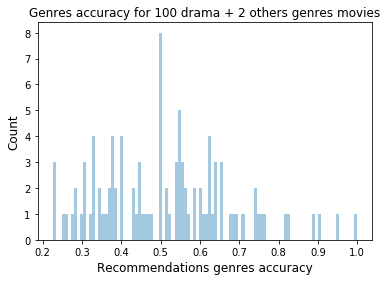

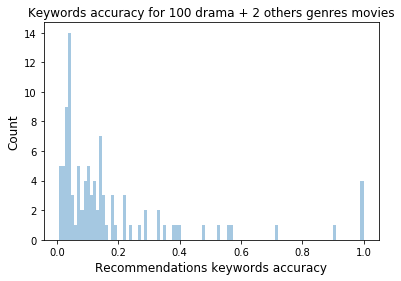

In [417]:
genres_acc_drama3 = []
kw_acc_drama3 = []
for i in range(0,len(drama3_movies)):
    dynamic_std_print('Movie %i / %i' % (i, len(drama3_movies) - 1))
    # Movie id
    temp_movie_id = drama3_movies.iloc[i].name
    # Extract weights
    recom_movie, movies_weights = extract_embedding(layer, temp_movie_id)
    # Get recommendations (closest movies)
    recom_df = genres_kw_df.loc[recom_movie[1:], ['title', 'genres', 'keywords']]
    # Get recommendations genres
    genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
    # Count genres of selected movie
    n_genres = len(genres_kw_df.loc[temp_movie_id, :].genres_list)
    # Process recommendation genres
    genres_recommendation = recom_genres(genres_kw_df.loc[temp_movie_id, :].genres, recom_df)
    # Compute genres accuracy for recommendations
    genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
    genres_acc_drama3.append(genres_accuracy)
    # Count kw of selected movie
    n_kw = len(genres_kw_df.loc[temp_movie_id, :].kw_list)
    # Process recommendation keywords
    keywords_recommendation = recom_kw(genres_kw_df.loc[temp_movie_id, :].keywords, recom_df)
    # Compute kw accuracy for recommendations
    kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
    kw_acc_drama3.append(kw_accuracy)
    
# Genres plot
fig, ax = plt.subplots()
ax = sns.distplot(genres_acc_drama3, bins=100, kde=False)
ax.set_xlabel("Recommendations genres accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Genres accuracy for 100 drama + 2 others genres movies", fontsize=12)
# Keywords plot
fig, ax = plt.subplots()
ax = sns.distplot(kw_acc_drama3, bins=100, kde=False)
ax.set_xlabel("Recommendations keywords accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Keywords accuracy for 100 drama + 2 others genres movies", fontsize=12);

### 6) Comedy + 2 others genres movies test

Movie 99 / 99

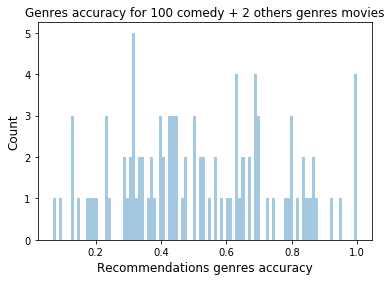

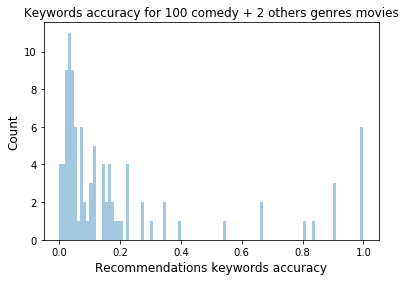

In [418]:
genres_acc_comedy3 = []
kw_acc_comedy3 = []
for i in range(0,len(comedy3_movies)):
    dynamic_std_print('Movie %i / %i' % (i, len(comedy3_movies) - 1))
    # Movie id
    temp_movie_id = comedy3_movies.iloc[i].name
    # Extract weights
    recom_movie, movies_weights = extract_embedding(layer, temp_movie_id)
    # Get recommendations (closest movies)
    recom_df = genres_kw_df.loc[recom_movie[1:], ['title', 'genres', 'keywords']]
    # Get recommendations genres
    genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
    # Count genres of selected movie
    n_genres = len(genres_kw_df.loc[temp_movie_id, :].genres_list)
    # Process recommendation genres
    genres_recommendation = recom_genres(genres_kw_df.loc[temp_movie_id, :].genres, recom_df)
    # Compute genres accuracy for recommendations
    genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
    genres_acc_comedy3.append(genres_accuracy)
    # Count kw of selected movie
    n_kw = len(genres_kw_df.loc[temp_movie_id, :].kw_list)
    # Process recommendation keywords
    keywords_recommendation = recom_kw(genres_kw_df.loc[temp_movie_id, :].keywords, recom_df)
    # Compute kw accuracy for recommendations
    kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
    kw_acc_comedy3.append(kw_accuracy)
    
# Genres plot
fig, ax = plt.subplots()
ax = sns.distplot(genres_acc_comedy3, bins=100, kde=False)
ax.set_xlabel("Recommendations genres accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Genres accuracy for 100 comedy + 2 others genres movies", fontsize=12)
# Keywords plot
fig, ax = plt.subplots()
ax = sns.distplot(kw_acc_comedy3, bins=100, kde=False)
ax.set_xlabel("Recommendations keywords accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Keywords accuracy for 100 comedy + 2 others genres movies", fontsize=12);

### 7) woman director movies test

Movie 99 / 99

/home/noel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


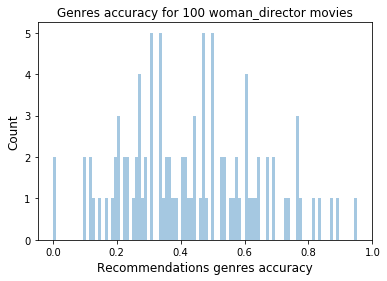

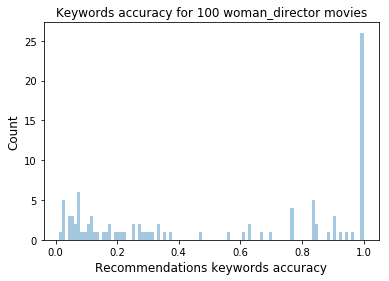

In [452]:
genres_acc_woman_director = []
kw_acc_woman_director = []
for i in range(0,len(woman_director_movies)):
    dynamic_std_print('Movie %i / %i' % (i, len(woman_director_movies) - 1))
    # Movie id
    temp_movie_id = woman_director_movies.iloc[i].name
    # Extract weights
    recom_movie, movies_weights = extract_embedding(layer, temp_movie_id)
    # Get recommendations (closest movies)
    recom_df = genres_kw_df.loc[recom_movie[1:], ['title', 'genres', 'keywords']]
    # Get recommendations genres
    genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
    # Count genres of selected movie
    n_genres = len(genres_kw_df.loc[temp_movie_id, :].genres_list)
    # Process recommendation genres
    genres_recommendation = recom_genres(genres_kw_df.loc[temp_movie_id, :].genres, recom_df)
    # Compute genres accuracy for recommendations
    genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
    genres_acc_woman_director.append(genres_accuracy)
    # Count kw of selected movie
    n_kw = len(genres_kw_df.loc[temp_movie_id, :].kw_list)
    # Process recommendation keywords
    keywords_recommendation = recom_kw(genres_kw_df.loc[temp_movie_id, :].keywords, recom_df)
    # Compute kw accuracy for recommendations
    kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
    kw_acc_woman_director.append(kw_accuracy)
    
# Genres plot
fig, ax = plt.subplots()
ax = sns.distplot(genres_acc_woman_director, bins=100, kde=False)
ax.set_xlabel("Recommendations genres accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Genres accuracy for 100 woman_director movies", fontsize=12)
# Keywords plot
fig, ax = plt.subplots()
ax = sns.distplot(kw_acc_woman_director, bins=100, kde=False)
ax.set_xlabel("Recommendations keywords accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Keywords accuracy for 100 woman_director movies", fontsize=12);

### 8) revenge movies test

Movie 99 / 99

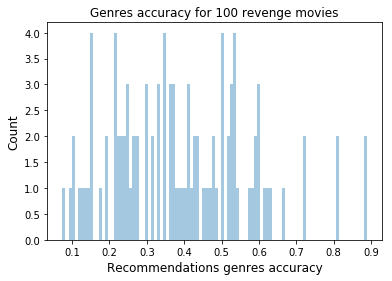

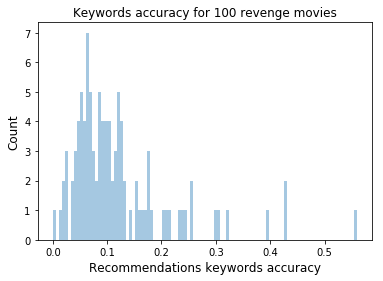

In [453]:
genres_acc_revenge = []
kw_acc_revenge = []
for i in range(0,len(revenge_movies)):
    dynamic_std_print('Movie %i / %i' % (i, len(revenge_movies) - 1))
    # Movie id
    temp_movie_id = revenge_movies.iloc[i].name
    # Extract weights
    recom_movie, movies_weights = extract_embedding(layer, temp_movie_id)
    # Get recommendations (closest movies)
    recom_df = genres_kw_df.loc[recom_movie[1:], ['title', 'genres', 'keywords']]
    # Get recommendations genres
    genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
    # Count genres of selected movie
    n_genres = len(genres_kw_df.loc[temp_movie_id, :].genres_list)
    # Process recommendation genres
    genres_recommendation = recom_genres(genres_kw_df.loc[temp_movie_id, :].genres, recom_df)
    # Compute genres accuracy for recommendations
    genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
    genres_acc_revenge.append(genres_accuracy)
    # Count kw of selected movie
    n_kw = len(genres_kw_df.loc[temp_movie_id, :].kw_list)
    # Process recommendation keywords
    keywords_recommendation = recom_kw(genres_kw_df.loc[temp_movie_id, :].keywords, recom_df)
    # Compute kw accuracy for recommendations
    kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
    kw_acc_revenge.append(kw_accuracy)
    
# Genres plot
fig, ax = plt.subplots()
ax = sns.distplot(genres_acc_revenge, bins=100, kde=False)
ax.set_xlabel("Recommendations genres accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Genres accuracy for 100 revenge movies", fontsize=12)
# Keywords plot
fig, ax = plt.subplots()
ax = sns.distplot(kw_acc_revenge, bins=100, kde=False)
ax.set_xlabel("Recommendations keywords accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Keywords accuracy for 100 revenge movies", fontsize=12);

### 9) robot movies test

Movie 99 / 99

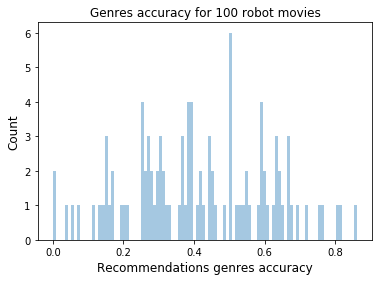

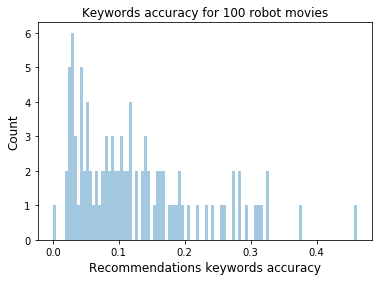

In [454]:
genres_acc_robot = []
kw_acc_robot = []
for i in range(0,len(robot_movies)):
    dynamic_std_print('Movie %i / %i' % (i, len(robot_movies) - 1))
    # Movie id
    temp_movie_id = robot_movies.iloc[i].name
    # Extract weights
    recom_movie, movies_weights = extract_embedding(layer, temp_movie_id)
    # Get recommendations (closest movies)
    recom_df = genres_kw_df.loc[recom_movie[1:], ['title', 'genres', 'keywords']]
    # Get recommendations genres
    genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
    # Count genres of selected movie
    n_genres = len(genres_kw_df.loc[temp_movie_id, :].genres_list)
    # Process recommendation genres
    genres_recommendation = recom_genres(genres_kw_df.loc[temp_movie_id, :].genres, recom_df)
    # Compute genres accuracy for recommendations
    genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
    genres_acc_robot.append(genres_accuracy)
    # Count kw of selected movie
    n_kw = len(genres_kw_df.loc[temp_movie_id, :].kw_list)
    # Process recommendation keywords
    keywords_recommendation = recom_kw(genres_kw_df.loc[temp_movie_id, :].keywords, recom_df)
    # Compute kw accuracy for recommendations
    kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
    kw_acc_robot.append(kw_accuracy)
    
# Genres plot
fig, ax = plt.subplots()
ax = sns.distplot(genres_acc_robot, bins=100, kde=False)
ax.set_xlabel("Recommendations genres accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Genres accuracy for 100 robot movies", fontsize=12)
# Keywords plot
fig, ax = plt.subplots()
ax = sns.distplot(kw_acc_robot, bins=100, kde=False)
ax.set_xlabel("Recommendations keywords accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Keywords accuracy for 100 robot movies", fontsize=12);

### 10) skyscraper movies test

Movie 19 / 19

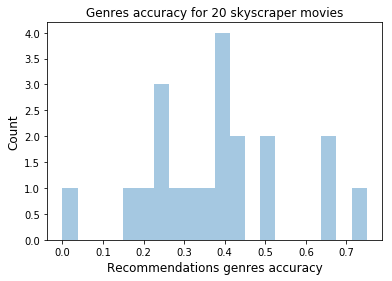

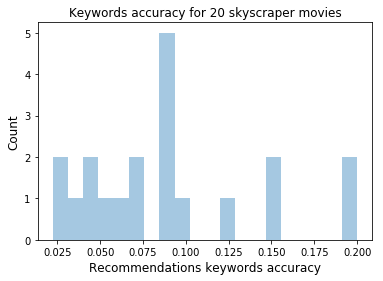

In [455]:
genres_acc_skyscraper = []
kw_acc_skyscraper = []
for i in range(0,len(skyscraper_movies)):
    dynamic_std_print('Movie %i / %i' % (i, len(skyscraper_movies) - 1))
    # Movie id
    temp_movie_id = skyscraper_movies.iloc[i].name
    # Extract weights
    recom_movie, movies_weights = extract_embedding(layer, temp_movie_id)
    # Get recommendations (closest movies)
    recom_df = genres_kw_df.loc[recom_movie[1:], ['title', 'genres', 'keywords']]
    # Get recommendations genres
    genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
    # Count genres of selected movie
    n_genres = len(genres_kw_df.loc[temp_movie_id, :].genres_list)
    # Process recommendation genres
    genres_recommendation = recom_genres(genres_kw_df.loc[temp_movie_id, :].genres, recom_df)
    # Compute genres accuracy for recommendations
    genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
    genres_acc_skyscraper.append(genres_accuracy)
    # Count kw of selected movie
    n_kw = len(genres_kw_df.loc[temp_movie_id, :].kw_list)
    # Process recommendation keywords
    keywords_recommendation = recom_kw(genres_kw_df.loc[temp_movie_id, :].keywords, recom_df)
    # Compute kw accuracy for recommendations
    kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
    kw_acc_skyscraper.append(kw_accuracy)
    
# Genres plot
fig, ax = plt.subplots()
ax = sns.distplot(genres_acc_skyscraper, bins=20, kde=False)
ax.set_xlabel("Recommendations genres accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Genres accuracy for 20 skyscraper movies", fontsize=12)
# Keywords plot
fig, ax = plt.subplots()
ax = sns.distplot(kw_acc_skyscraper, bins=20, kde=False)
ax.set_xlabel("Recommendations keywords accuracy", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Keywords accuracy for 20 skyscraper movies", fontsize=12);

## Importing movies valid id from JSON file

In [26]:
import json
# reading the JSON data using json.load()
file = 'movie_ids_02_16_2019.json'
movies = []
with open(file) as ids_file:
    for line in ids_file:
        movies.append(json.loads(line))

# converting json dataset from dictionary to dataframe
movies_ids_df = pd.DataFrame(movies)
movies_ids_df.reset_index(level=0, inplace=True)

In [27]:
valid_ids = movies_ids_df.id.values.tolist()
valid_ids.sort()

In [4]:
import pickle
# pickle.dump(valid_ids, open('valid_imdb_ids.pkl', 'wb'), protocol=2)